In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
# importing all the horrors imaginable

# Data loading and preprocessing

In [2]:
# dataframe of features
df_X = pd.read_csv('Train_call.txt', sep='\t')
df_X.head(3)

,Chromosome,Start,End,Nclone,Array.129,Array.34,Array.67,Array.24,Array.22,Array.36,...,Array.64,Array.89,Array.30,Array.35,Array.93,Array.10,Array.123,Array.100,Array.134,Array.130
0,1,2927,43870,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
1,1,85022,216735,4,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
2,1,370546,372295,4,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,-1,0


In [3]:
df_X.shape

(2834, 104)

In [4]:
# loading annotations
df_y = pd.read_csv('Train_clinical.txt', sep='\t')
df_y.head(3)

,Sample,Subgroup
0,Array.129,HER2+
1,Array.34,HR+
2,Array.67,HR+


In [5]:
df_y.Subgroup.value_counts()

Subgroup
HR+           36
HER2+         32
Triple Neg    32
Name: count, dtype: int64

In [6]:
# we gonna remap the Subgroup to a number
mapper = {
    'HER2+': 0,
    'HR+': 1,
    'Triple Neg': 2
}

In [7]:
df_y['y'] = df_y.apply(lambda x: mapper[x['Subgroup']], axis=1)
df_y.head(3)

,Sample,Subgroup,y
0,Array.129,HER2+,0
1,Array.34,HR+,1
2,Array.67,HR+,1


In [8]:
# we will have to rotate the data, since provided trash is with rows as features
df_X.T.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833
Chromosome,1,1,1,1,1,1,1,1,1,1,...,23,23,23,23,23,23,23,23,23,23
Start,2927,85022,370546,471671,792533,912799,1271190,1676445,1738295,2481927,...,151067607,152422390,152552851,152576854,152994680,153062077,153466463,153504394,153938998,153997146
End,43870,216735,372295,786483,907406,1266212,1590570,1703748,2477597,2562342,...,152416606,152548587,152570071,152935130,153054487,153452633,153491568,153933426,153989329,154492924
Nclone,3,4,4,5,13,96,45,4,104,14,...,159,20,6,64,5,57,4,55,5,43
Array.129,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,0,1,1,1,1,1


In [9]:
# this code selects regions where genes are physically located
gene_mapper = {
    'ERBB2': [17, 35104766, 35138441], # consult readme for more details
    'PGR': [11, 100414313, 100506465],
    'ESR1': [6, 152053324, 152466099],
    'ESR2': [14, 63763506, 63875021],
}

def region_selector(row):
    # checks if this chromosome has a gene
    gene_match = [
        gene for gene in gene_mapper if gene_mapper[gene][0] == row['Chromosome']
    ] # TODO: change if two genes on the same chromosome
    if gene_match:
        gene_match = gene_match[0]
        gene_range = gene_mapper[gene_match]
        if (row['Start'] <= gene_range[2] and row['End'] >= gene_range[1]) or \
        (row['Start'] >= gene_range[1] and row['End'] <= gene_range[2]) or \
        (row['Start'] <= gene_range[1] and row['End'] >= gene_range[1]):
            row['gene'] = gene_match
            return row
    else:
        return None

In [10]:
selected_rows = [
    region_selector(row) for _, row in df_X.iterrows() if region_selector(row) is not None
]

In [11]:
X_train_preselected = pd.concat(selected_rows, axis=1, ignore_index=False)
X_train_selected = X_train_preselected.drop(['Chromosome', 'Start', 'End', 'Nclone', 'gene'])
X_train_selected = X_train_selected.astype('int64')
# selected locationons where genes of interest are located
X_train_selected.head()

,876,877,878,1577,1841,2184
Array.129,-1,-1,-1,-1,0,2
Array.34,-1,-1,-1,1,-1,0
Array.67,-1,-1,-1,0,1,-1
Array.24,-1,-1,-1,0,-1,0
Array.22,-1,-1,-1,-1,0,0


In [12]:
# remove trash (I mean not needed information)
X_train_full = df_X.T.drop(['Chromosome', 'Start', 'End', 'Nclone'])#, 'gene'])

## Splitting the data

In [13]:
cv_folds = 3 # number of folds for cross-validation
cv = StratifiedKFold(n_splits=cv_folds, random_state=43, shuffle=True)
# I am using StratifiedKFold to make sure that each fold has the same proportion of classes as the whole dataset

## Let's play

In [14]:
# starting with meta
import multiprocessing


def perform_crossval_xgb(X_train: pd.DataFrame, y_train: pd.DataFrame, cv: StratifiedKFold):
    scores = []
    # clf = RandomForestClassifier()
    clf = xgb.XGBClassifier(tree_method="hist", 
                            n_jobs=multiprocessing.cpu_count() // 2,
                            # early_stopping_rounds=3
                            )
    
    for train_index, test_index in cv.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
        # clf.fit(X_train_cv, y_train_cv, eval_set=[(X_test_cv, y_test_cv)], verbose=False)
        clf.fit(X_train_cv, y_train_cv
                #, eval_set=[(X_test_cv, y_test_cv)], verbose=False)
        )
        scores.append(clf.score(X_test_cv, y_test_cv))
    return scores

In [15]:
scores_full_xgb = perform_crossval_xgb(X_train_full, df_y['y'], cv)

In [16]:
# same but trained on selected regions
scores_selected_xgb = perform_crossval_xgb(X_train_selected, df_y['y'], cv)

In [17]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores_full_rf = cross_val_score(
    clf, X_train_full, df_y['y'], cv=cv
)    

In [18]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores_selected_rf = cross_val_score(
    clf, X_train_selected, df_y['y'], cv=cv
)

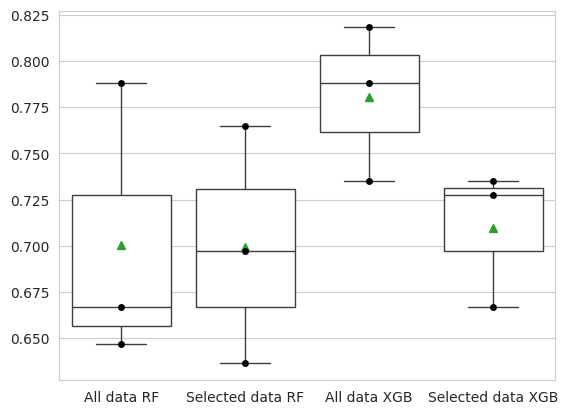

In [19]:
sns.set_style("whitegrid")
# plot all 4 experiments
sns.boxplot(data=[scores_full_rf, scores_selected_rf, scores_full_xgb, scores_selected_xgb], showmeans=True, color='w')

sns.swarmplot(data=[scores_full_rf, scores_selected_rf, scores_full_xgb, scores_selected_xgb], color='black')

plt.xticks([0, 1, 2, 3], ['All data RF', 'Selected data RF', 'All data XGB', 'Selected data XGB']);

Text(0.5, 1.0, 'Shows connections between cross-folds')

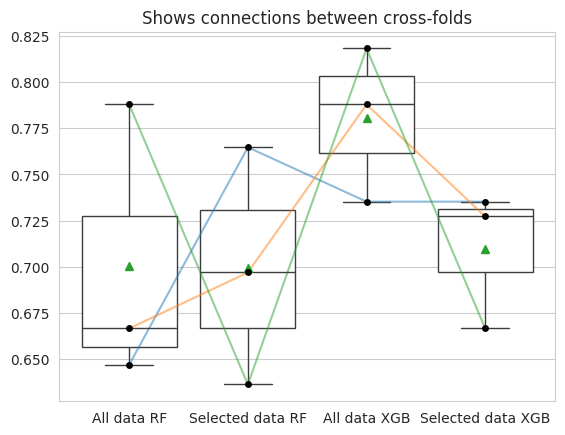

In [20]:
sns.boxplot(data=[scores_full_rf, scores_selected_rf, scores_full_xgb, scores_selected_xgb], showmeans=True, color='w')

sns.swarmplot(data=[scores_full_rf, scores_selected_rf, scores_full_xgb, scores_selected_xgb], color='black')

plt.xticks([0, 1, 2, 3], ['All data RF', 'Selected data RF', 'All data XGB', 'Selected data XGB']);
for i in range(3):
    plt.plot([0, 1, 2, 3], [scores_full_rf[i], scores_selected_rf[i], scores_full_xgb[i], scores_selected_xgb[i]], alpha=0.5)
plt.title('Shows connections between cross-folds')

# Exploring feature importance of full data

In [21]:
# train eval split
X_train, X_eval, y_train, y_eval = train_test_split(X_train_full, df_y['y'], test_size=0.1, random_state=42, stratify=df_y['y'])

In [22]:
# train xgboost
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
clf.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=True);

[0]	validation_0-mlogloss:0.83273
[1]	validation_0-mlogloss:0.69716
[2]	validation_0-mlogloss:0.58176
[3]	validation_0-mlogloss:0.51546
[4]	validation_0-mlogloss:0.47627
[5]	validation_0-mlogloss:0.43561
[6]	validation_0-mlogloss:0.41063
[7]	validation_0-mlogloss:0.37906
[8]	validation_0-mlogloss:0.34580
[9]	validation_0-mlogloss:0.32520
[10]	validation_0-mlogloss:0.30439
[11]	validation_0-mlogloss:0.31239
[12]	validation_0-mlogloss:0.29858
[13]	validation_0-mlogloss:0.30069
[14]	validation_0-mlogloss:0.30662


In [23]:
importance = clf.feature_importances_
features = X_train.columns
importance_dict = dict(zip(features, importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

In [24]:
importance_df = pd.DataFrame(sorted_importance, columns=['feature', 'importance'])
importance_df.head()
# most important features

,feature,importance
0,740,0.083861
1,2184,0.078499
2,1899,0.043978
3,1677,0.037343
4,195,0.037282


In [25]:
gene_idxs = X_train_preselected.columns.to_list()
gene_idxs
# features that are genes of interest sort of

[876, 877, 878, 1577, 1841, 2184]

In [26]:
importance_df[importance_df['feature'].isin(gene_idxs)]

,feature,importance
1,2184,0.078499
930,876,0.000000
931,877,0.000000
932,878,0.000000
1619,1577,0.000000
1877,1841,0.000000


In [27]:
# Not all of the genes turns out important...
# Well, 2184 has the biggest importance, which is ERBB2 gene
# but others have small importance, which means they are either not mapped correctly
# or the annotations are wrong, or they are jumping genes or whataver

In [28]:
mapping_df = pd.read_csv('BasepairToGeneMap.tsv', sep='\t')

In [29]:
importance_df.iloc[:10, 0].values

array([ 740, 2184, 1899, 1677,  195,  694, 2021, 1900,   58, 1655])

In [30]:
mapping_df.dtypes

ENSEMBL_gene_id    object
Chromosome         object
Gene_start          int64
Gene_end            int64
HGNC_symbol        object
dtype: object

In [31]:
df_X.Chromosome.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])

In [32]:
mapping_df.Chromosome.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X',
       'Y'], dtype=object)

In [33]:
# df_X Crhomosome to object str
df_X['Chromosome'] = df_X['Chromosome'].astype(str)

In [34]:
# make columns Gene_start and Gene_end integers
mapping_df['Gene_start'] = mapping_df['Gene_start'].astype('int64')
mapping_df['Gene_end'] = mapping_df['Gene_end'].astype('int64')

In [35]:
locations_of_interest = df_X.T.iloc[:3, importance_df.iloc[:10, 0].values].T
locations_of_interest

,Chromosome,Start,End
740,6,14553443,16323782
2184,17,35076296,35282086
1899,15,27009381,32443495
1677,12,84542006,85443011
195,1,149591108,149598429
694,5,150148732,150201145
2021,16,68710277,68751390
1900,15,32447707,32511475
58,1,30716764,30984527
1655,12,63574243,64694907


In [36]:
# find those genes that overlap with locations of interest
def find_genes(row):
    genes_within = []
    # create selected mapping where Chromosome is the same
    selected_mapping = mapping_df[mapping_df['Chromosome'] == row['Chromosome']]
    
    # print(selected_mapping)
    
    for _, gene_row in selected_mapping.iterrows():
        # count partial overlap also
        # print(row['Start'], gene_row['Gene_end'], row['End'], gene_row['Gene_start'])
        # break
        if (row['Start'] <= gene_row['Gene_end'] and row['End'] >= gene_row['Gene_start']) or \
        (row['Start'] >= gene_row['Gene_start'] and row['End'] <= gene_row['Gene_end']) or \
        (row['Start'] <= gene_row['Gene_start'] and row['End'] >= gene_row['Gene_start']):
            
            genes_within.append(gene_row.to_frame().T)
            
            
    return pd.concat(genes_within, axis=0) if genes_within else None

In [37]:
temp = []
for _, row in locations_of_interest.iterrows():
    locs = find_genes(row)
    if locs is None:
        continue
    locs['region_selector'] = row.name
    locs['region_start'] = row['Start']
    locs['region_end'] = row['End']
    # print(locs.shape)
    temp.append(locs)
df_selected_genes = pd.concat(temp, axis=0)

In [38]:
from Bio import Entrez

In [39]:
df_selected_genes.columns

Index(['ENSEMBL_gene_id', 'Chromosome', 'Gene_start', 'Gene_end',
       'HGNC_symbol', 'region_selector', 'region_start', 'region_end'],
      dtype='object')

In [40]:
Entrez.email = 'gg@gmail.com'
gene_ids = df_selected_genes['ENSEMBL_gene_id'].unique().tolist()
gene_ids[:3]

['ENSG00000206960', 'ENSG00000216754', 'ENSG00000210041']

In [41]:
handle = Entrez.efetch(db="gene", id='ENSG00000206960', retmode="xml")
record = Entrez.read(handle)
record[0]


{'Entrezgene_track-info': {'Gene-track': {'Gene-track_geneid': '206960', 'Gene-track_status': StringElement('2', attributes={'value': 'discontinued'}), 'Gene-track_create-date': {'Date': {'Date_std': {'Date-std': {'Date-std_year': '2002', 'Date-std_month': '5', 'Date-std_day': '1'}}}}, 'Gene-track_update-date': {'Date': {'Date_std': {'Date-std': {'Date-std_year': '2017', 'Date-std_month': '4', 'Date-std_day': '8'}}}}, 'Gene-track_discontinue-date': {'Date': {'Date_std': {'Date-std': {'Date-std_year': '2005', 'Date-std_month': '5', 'Date-std_day': '10', 'Date-std_hour': '10', 'Date-std_minute': '5', 'Date-std_second': '0'}}}}}}, 'Entrezgene_type': StringElement('6', attributes={'value': 'protein-coding'}), 'Entrezgene_source': {'BioSource': {'BioSource_genome': StringElement('1', attributes={'value': 'genomic'}), 'BioSource_origin': StringElement('1', attributes={'value': 'natural'}), 'BioSource_org': {'Org-ref': {'Org-ref_taxname': 'Homo sapiens', 'Org-ref_common': 'human', 'Org-ref_db

### Repeating the same thingie for linear regression

In [42]:
# train linear classifier
clf = LogisticRegression()
clf.fit(X_train_full, df_y['y'])
# get feature importance
importance = clf.coef_[0]
features = X_train_full.columns
importance_dict = dict(zip(features, importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
linear_importance_df = pd.DataFrame(sorted_importance, columns=['feature', 'importance'])

In [43]:
linear_importance_df.head(10)

,feature,importance
0,2184,0.338548
1,2183,0.150001
2,2182,0.142836
3,2185,0.130784
4,2186,0.128018
5,621,0.076994
6,620,0.067730
7,2154,0.058875
8,548,0.058360
9,1527,0.056642


In [44]:
linear_importance_df[linear_importance_df['feature'].isin(gene_idxs)]

,feature,importance
0,2184,0.338548
1052,1841,0.003921
1316,1577,0.000706
2070,877,-0.009206
2125,878,-0.009951
2192,876,-0.011141


In [45]:
# well, idk what's wrong but SHAP might show us the way